   ![alt text](https://www.mbari.org/wp-content/uploads/2014/11/logo-mbari-3b.png "MBARI")

  <div align="left">Copyright (c) 2022, MBARI</div>
    
  * Distributed under the terms of the GPL License
  * Maintainer: ryjo@mbari.org
  * Authors: John Ryan ryjo@mbari.org

## Shipping Noise Analysis
---
This tutorial describes use of the *Pacific Ocean Sound Recordings* archive to examine variation in a major source of noise in the ocean: shipping.  Because the lower frequencies of shipping noise travel farther and are thus more detectable regionally, we can use audio data with a relatively low sample rate to examine it.  For efficiency, this tutorial uses the 2 kHz data archive (decimated from the original 256 kHz recordings).  The derived metric is mean-square sound pressure spectral density in the one-third octave band centered at 63 Hz, an [international standard](https://publications.jrc.ec.europa.eu/repository/handle/JRC88045).  This tutorial covers reading and processing of the audio data to produce the metric, and examination of time-series results.  It is based on the methods of a [recent publication](https://www.frontiersin.org/articles/10.3389/fmars.2021.656566/full) that showed reduction of shipping noise during onset of the COVID-19 pandemic.

If you use this data set, please **[cite our project](https://ieeexplore.ieee.org/document/7761363).**


## Data Overview
---

### Recording site
The [recording site](https://www.mbari.org/at-sea/cabled-observatory/) is located on the continental slope of the eastern North Pacific, within [Monterey Bay National Marine Sanctuary](https://montereybay.noaa.gov/). This site is not near any major ports, thus it does not experience extremely high levels of shipping noise.  However, offshore shipping lanes pass within approximately 20 km of the recorder, and the noise of shipping is a significant part of the local soundscape.

### Hydrophone calibration
For the low-frequency (2 kHz) data, calibration data are not frequency dependent; a single low-frequency calibration value is used.  Its value depends on time of data collection, as two hydrophones have been deployed sequentially at the same site.  Before 14 June 2017, the calibration value is -168.8 dB re V / uPa (measured at 26 Hz).  After this date the value is -177.9 dB re V / uPa (measured at 250 Hz).

Further calibration details can for the first calibration deployement and
*   https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment01.json
*   https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment02.json

There is an important distinction between the deployed hydrophones, relevant to time-series analysis.  The first hydrophone exhibited calibration drift, while the second (deployed 13 June 2017 and currently operational) has not.  This observation is consistent with differences in the technologies of the two instruments.  What it means for this application is that time-series analysis of shipping noise should be constrained to the period of the second hydrophone deployment.

### Data files and archive organization
The decimated audio data are in daily [WAV](https://en.wikipedia.org/wiki/WAV) files in an s3 bucket named <b>pacific-sound-2khz</b>, grouped by year and month.  Buckets are stored as objects, so the data are not physically stored in folders or directories as you may be famaliar with, but you can think of it conceptually as follows:

```
pacific-sound-2khz
      |
      ----2020
        |
        |----01
        ...
        |----12
```


## Install required dependencies

First, let's install the required software dependencies. 

If you are using this notebook in a cloud environment, select a Python3 compatible kernel and run this next section.  This only needs to be done once for the duration of this notebook.

If you are working on local computer, you can skip this next cell. Change your kernel to *pacific-sound-notebooks*, which you installed according to the instructions in the [README](https://github.com/mbari-org/pacific-sound-notebooks/) - this has all the dependencies that are needed. 

In [1]:
!pip install -q boto3 --quiet
!pip install -q soundfile --quiet
!pip install -q scipy --quiet
!pip install -q numpy --quiet
!pip install -q matplotlib --quiet

     |████████████████████████████████| 132 kB 14.3 MB/s 
     |████████████████████████████████| 79 kB 7.2 MB/s 
     |████████████████████████████████| 9.2 MB 78.3 MB/s 
     |████████████████████████████████| 140 kB 74.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.12 which is incompatible.


### Import all packages

In [2]:
import boto3, botocore
from botocore import UNSIGNED
from botocore.client import Config
from six.moves.urllib.request import urlopen
import io
import scipy
from scipy import signal
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

## Data Access
---
This section covers file listing, metadata retrieval, and data loading.

### List files
Files are organized by year and month; list all of the files available for one month of one year.

In [3]:
s3 = boto3.client('s3',
    aws_access_key_id='',
    aws_secret_access_key='', 
    config=Config(signature_version=UNSIGNED))

In [4]:
year = "2021"
month = "05"
bucket = 'pacific-sound-2khz'

for obj in s3.list_objects_v2(Bucket=bucket, Prefix=f'{year}/{month}')['Contents']:
    print(obj['Key'])

2021/05/MARS-20210501T000000Z-2kHz.wav
2021/05/MARS-20210502T000000Z-2kHz.wav
2021/05/MARS-20210503T000000Z-2kHz.wav
2021/05/MARS-20210504T000000Z-2kHz.wav
2021/05/MARS-20210505T000000Z-2kHz.wav
2021/05/MARS-20210506T000000Z-2kHz.wav
2021/05/MARS-20210507T000000Z-2kHz.wav
2021/05/MARS-20210508T000000Z-2kHz.wav
2021/05/MARS-20210509T000000Z-2kHz.wav
2021/05/MARS-20210510T000000Z-2kHz.wav
2021/05/MARS-20210511T000000Z-2kHz.wav
2021/05/MARS-20210512T000000Z-2kHz.wav
2021/05/MARS-20210513T000000Z-2kHz.wav
2021/05/MARS-20210514T000000Z-2kHz.wav
2021/05/MARS-20210515T000000Z-2kHz.wav
2021/05/MARS-20210516T000000Z-2kHz.wav
2021/05/MARS-20210517T000000Z-2kHz.wav
2021/05/MARS-20210518T000000Z-2kHz.wav
2021/05/MARS-20210519T000000Z-2kHz.wav
2021/05/MARS-20210520T000000Z-2kHz.wav
2021/05/MARS-20210521T000000Z-2kHz.wav
2021/05/MARS-20210522T000000Z-2kHz.wav
2021/05/MARS-20210523T000000Z-2kHz.wav
2021/05/MARS-20210524T000000Z-2kHz.wav
2021/05/MARS-20210525T000000Z-2kHz.wav
2021/05/MARS-20210526T000

### Retrieve metadata
Read and show metadata for a single daily file.

In [5]:
year = "2021"
month = "05"
filename = 'MARS-20210521T000000Z-2kHz.wav'
bucket = 'pacific-sound-2khz'
key = f'{year}/{month}/{filename}'

url = f'https://{bucket}.s3.amazonaws.com/{key}'

sf.info(io.BytesIO(urlopen(url).read(1_000)), verbose=True) 

samplerate: 2000 Hz
channels: 1
duration: 222 samples
format: WAV (Microsoft) [WAV]
subtype: Signed 24 bit PCM [PCM_24]
endian: FILE
sections: 1
frames: 222
extra_info: """
    Length : 1000
    RIFF : 518400324 (should be 992)
    WAVE
    fmt  : 16
      Format        : 0x1 => WAVE_FORMAT_PCM
      Channels      : 1
      Sample Rate   : 2000
      Block Align   : 3
      Bit Width     : 24
      Bytes/sec     : 6000
    LIST : 280
      INFO
        INAM : MBARI ocean audio data, start 20210521T000000 UTC
        ICMT : If you use these data, please cite https://doi.org/10.1109/OCEANS.2016.7761363. Recording metadata can be found at https://bitbucket.org/mbari/pacific-sound/src/master/MBARI_MARS_Hydrophone_Deployment02.json.
    data : 518400000 (should be 668)
    End
    """

### Load data
Read the full content of a single daily file.

In [6]:
# read full-day of data
print(f'Reading from {url}')
v, sample_rate = sf.read(io.BytesIO(urlopen(url).read()),dtype='float32') 
v = v*3   # convert scaled voltage to volts
num_secs = (v.size) / sample_rate # number of seconds in vector
print(f'Read {num_secs} seconds of data')

Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210521T000000Z-2kHz.wav
Read 86400.0 seconds of data


## Shipping noise metric
---
Our focal metric is the mean-square sound pressure spectral density, ISO 18405 3.1.3.13, for the one-third octave band centered at 63 Hz (ISO, 2017; Dekeling et al., 2014).  To compute this metric effectively, we must distinguish shipping noise from other signals in the same frequency band.  At this recording site, we have found that other signals (harmonics of blue whale vocalizations, mechanical disturbance of the recorder) can influence the metric (see examples in Figure 3 of [this paper](https://www.frontiersin.org/articles/10.3389/fmars.2021.656566/full)).  However, they are more ephemeral than shipping noise and their influence can be minimized simply by computing median values of the metric within a sufficiently long temporal bin.  A temporal bin of 1 minute is applied here to the focal metric computed at 1-second resolution.  Because the audio data have a DC offset and zeros are used to identify missing data, we also want to identify time periods of missing data using the percent of each minute having zero values.  This is important for screening values then enter into time-binned statistics.

### Compute spectrogram
The first step is to compute a spectrogram from non-overlapping 1-second segments.  A frequency resoltion of 1 Hz effectively enables averaging of power spectral density over the focal frequency band. 

In [7]:
# Compute spectrogram 
w = scipy.signal.get_window('hann',sample_rate)
f, t, psd = scipy.signal.spectrogram(v, sample_rate,nperseg=sample_rate,noverlap=0,window=w,nfft=sample_rate)
print(f':: psd.shape           = {psd.shape}')
print(f':: f.size              = {f.size}')
print(f':: t.size              = {t.size}')


:: psd.shape           = (1001, 86400)
:: f.size              = 1001
:: t.size              = 86400


### Extract focal frequency band
The next step is to average power spectral density for the one-third octave band centered at 63 Hz.  Band limits are rounded to the nearst Hz.

In [8]:
idx = np.where(np.logical_and(f>=56, f<=71))
print(f':: selected frequencies are {f[idx]}')
psd_sub = np.squeeze(psd[idx,:])
print(f':: psd_sub.shape          = {psd_sub.shape}')
# band psd
band_psd = np.mean(psd_sub, axis=0)
# Convert to dB
sens = -177.9  # hydrophone sensitivity for this file
band_psd = 10*np.log10(band_psd)-sens
print(f':: band_psd.size             = {band_psd.size}')
print(f':: min of band psd        = {min(band_psd)}')
print(f':: max of band pad        = {max(band_psd)}')

:: selected frequencies are [56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.]
:: psd_sub.shape          = (16, 86400)
:: band_psd.size             = 86400
:: min of band psd        = 72.78706359863281
:: max of band pad        = 120.67597961425781


### Compute 1-minute median (L50)
Finally, we compute median spectrum levels at 1 minute resolution.


:: band_psd.size           = 86400
:: L.shape             = (1440, 60)
:: L50.size            = 1440
:: min(L50)            = 78.15385437011719
:: max(L50)            = 91.43157958984375
:: L50sec.size         = 1440
:: min(L50sec)         = 30.0
:: max(L50sec)         = 86370.0
:: samples per minute  = 120000
:: zero count array shape    = (1440, 120000)


Text(0.5, 1.0, 'Zero values per minute in original data')

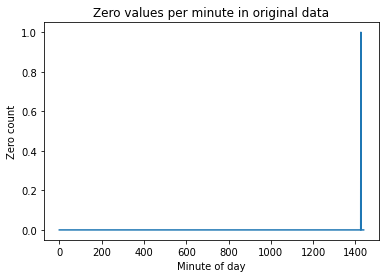

In [9]:
# reshape the 1-second vector
print(f':: band_psd.size           = {band_psd.size}')
L = np.reshape(band_psd,(1440,60))
print(f':: L.shape             = {L.shape}')
L50 = np.median(L,axis=1)
print(f':: L50.size            = {L50.size}')
print(f':: min(L50)            = {min(L50)}')
print(f':: max(L50)            = {max(L50)}')
# get a time reference for the 1-minute median
L50sec = np.linspace(30,86400-30,1440)
print(f':: L50sec.size         = {L50sec.size}')
print(f':: min(L50sec)         = {min(L50sec)}')
print(f':: max(L50sec)         = {max(L50sec)}')
# Quantify missing samples in each minute
samples_per_min = sample_rate * 60  # samples per minute
print(f':: samples per minute  = {samples_per_min}')
zero_check = np.reshape(v,(-1,samples_per_min))
print(f':: zero count array shape    = {zero_check.shape}')
zero_count = (zero_check == 0).sum(1)
plt.plot(zero_count)
plt.ylabel('Zero count')
plt.xlabel('Minute of day')
plt.title('Zero values per minute in original data')

In this day of recording, there was only a single zero value.  With the data having a DC offset, zero is a rare but possible real value.  In contrast, data gaps will be apparent as all samples in a series of minutes being zero.  We illustrate this in the time-series analysis section below.

### View results
Finally, plot the results - both the 1-second spectrum levels and 1-minute median values.

Text(0.5, 1.0, '1-second band PSD and 1-minute median')

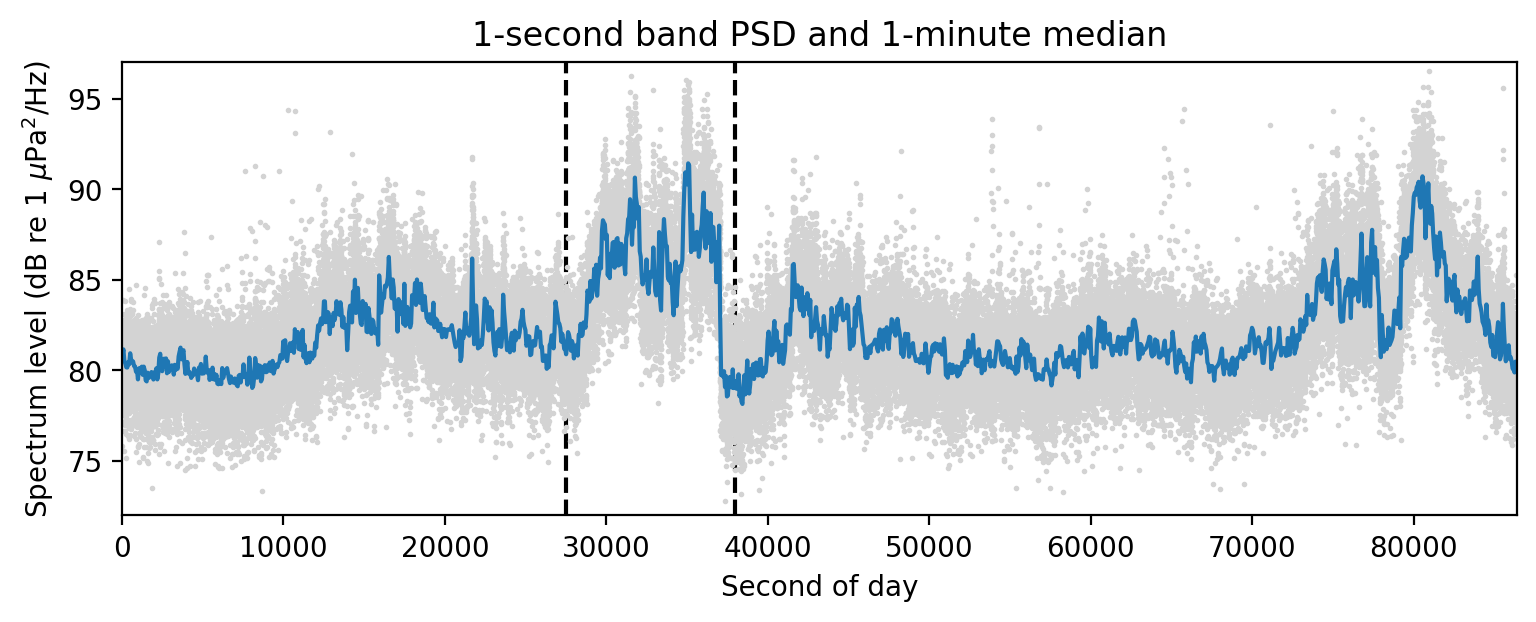

In [10]:
plt.figure(dpi=200, figsize = [9,3])
plt.plot(band_psd,".",color="lightgray",markersize=2)
plt.plot(L50sec,L50)
plt.vlines((27500,38000),ymin=72, ymax=97, linestyles="dashed")
plt.xlim(0,86400)
plt.ylim((72,97))
plt.xlabel("Second of day")
plt.ylabel("Spectrum level (dB re 1 $\mu$Pa$^2$/Hz)")
plt.title("1-second band PSD and 1-minute median")

The results above indicate multiple periods of elevated signal in the focal frequency band, with the strongest rise and fall during the period hilighted (between the dashed lines).  Let's take a look at the full spectrogram for that period.

Text(0.5, 1.0, 'Spectrum level (dB re 1 $\\mu$Pa$^2$/Hz)')

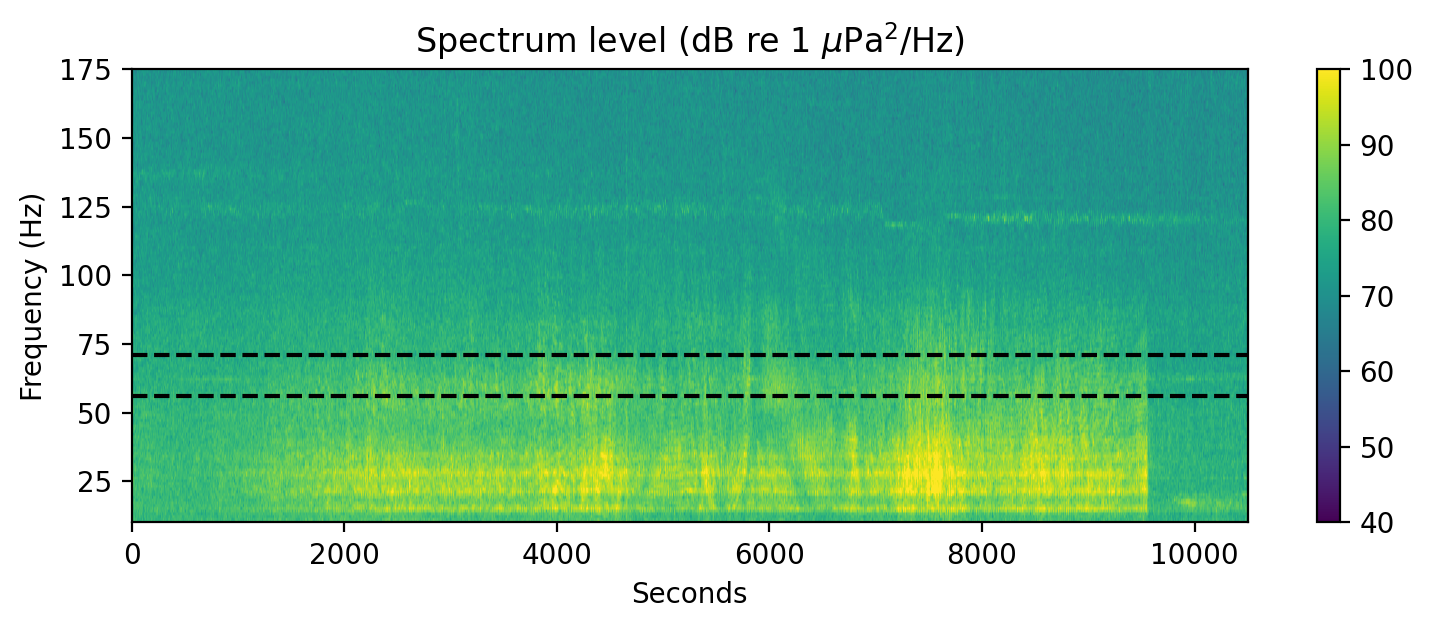

In [11]:
# Plot spectrogram for the highlighted time period.
# Exclude the highest frequencies (attenuated by the decimation filter). 
filter_index = np.where(np.logical_and(f >= 10, f <= 875))
filtered_psd = np.squeeze(10*np.log10(psd[filter_index,27500:38000])-sens)
plt.figure(dpi=200, figsize = [9,3])
plt.imshow(filtered_psd,aspect='auto',origin='lower',vmin=40,vmax=100)
num_secs = filtered_psd.shape[1]
plt.plot([1, num_secs-1],[56, 56],'k--')
plt.plot([1, num_secs-1],[71, 71],'k--')
plt.ylim(10,175)
plt.colorbar()
plt.xlabel('Seconds')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrum level (dB re 1 $\mu$Pa$^2$/Hz)')


Noise from distant shipping is largely below 100 Hz at this recording site, and we can see that the band used for the shipping noise metric (dashed black lines) captures the upper frequency limit of the noise.  Although shipping noise is much greater at lower frequencies, other sound sources in that lower frequencies would confound the analysis. 

## Time-series analysis
---
Now that we have illustrated the methods of computing 1-minute median spectrum levels for the focal frequency band, we can execute batch processing of the audio data to extract time-series statistics.  The study that motivated this tutorial examined monthly statistics across years.  For illustration puruposes here, we'll produce daily statistics for the month of the day examined above.

In [12]:
# Determine the number of data files available for the month
num_files = 0
for obj in s3.list_objects_v2(Bucket=bucket, Prefix=f'{year}/{month}')['Contents']:
    print(obj['Key'])
    num_files = num_files+1

2021/05/MARS-20210501T000000Z-2kHz.wav
2021/05/MARS-20210502T000000Z-2kHz.wav
2021/05/MARS-20210503T000000Z-2kHz.wav
2021/05/MARS-20210504T000000Z-2kHz.wav
2021/05/MARS-20210505T000000Z-2kHz.wav
2021/05/MARS-20210506T000000Z-2kHz.wav
2021/05/MARS-20210507T000000Z-2kHz.wav
2021/05/MARS-20210508T000000Z-2kHz.wav
2021/05/MARS-20210509T000000Z-2kHz.wav
2021/05/MARS-20210510T000000Z-2kHz.wav
2021/05/MARS-20210511T000000Z-2kHz.wav
2021/05/MARS-20210512T000000Z-2kHz.wav
2021/05/MARS-20210513T000000Z-2kHz.wav
2021/05/MARS-20210514T000000Z-2kHz.wav
2021/05/MARS-20210515T000000Z-2kHz.wav
2021/05/MARS-20210516T000000Z-2kHz.wav
2021/05/MARS-20210517T000000Z-2kHz.wav
2021/05/MARS-20210518T000000Z-2kHz.wav
2021/05/MARS-20210519T000000Z-2kHz.wav
2021/05/MARS-20210520T000000Z-2kHz.wav
2021/05/MARS-20210521T000000Z-2kHz.wav
2021/05/MARS-20210522T000000Z-2kHz.wav
2021/05/MARS-20210523T000000Z-2kHz.wav
2021/05/MARS-20210524T000000Z-2kHz.wav
2021/05/MARS-20210525T000000Z-2kHz.wav
2021/05/MARS-20210526T000

In [13]:
# Batch process the month of daily files

# Initialize arrays to hold 1-minute median and zero count results 
# dimensions: number of days x number of minutes per day
L50m = np.zeros((num_files,1440))
zero_count_daily = np.zeros((num_files,1440))
X = -1   # first row index will be 0 after increment

for obj in s3.list_objects_v2(Bucket=bucket, Prefix=f'{year}/{month}')['Contents']:
  # read file
  filename = obj['Key']
  url = f'https://{bucket}.s3.amazonaws.com/{filename}'
  print(f'Reading from {url}')
  v, fs = sf.read(io.BytesIO(urlopen(url).read()),dtype='float32')
  v = v*3   # convert scaled voltage to volts
  # Compute spectrogram 
  f, t, psd = scipy.signal.spectrogram(v, fs,nperseg=fs,noverlap=0,window=w,nfft=fs)
  # Average for one-third octave band centered at 63 Hz
  idx = np.where(np.logical_and(f>=56, f<=71))
  psd_sub = np.squeeze(psd[idx,:])
  band_psd = np.mean(psd_sub,axis=0)
  band_psd = 10*np.log10(band_psd)-sens   # conver to dB
  # 1-minute median
  band_psd_median = np.median(np.reshape(band_psd,(1440,60)),axis=1)
  # zero count
  zero_check = np.reshape(v,(-1,samples_per_min))
  zero_count = (zero_check == 0).sum(1)
  # Place in monthly arrays
  X = X+1
  L50m[X,:] = band_psd_median
  zero_count_daily[X,:] = zero_count
  

Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210501T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210502T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210503T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210504T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210505T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210506T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210507T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210508T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210509T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210510T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210513T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210514T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210515T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210516T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210517T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210518T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210519T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210520T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210521T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.s3.amazonaws.com/2021/05/MARS-20210522T000000Z-2kHz.wav
Reading from https://pacific-sound-2khz.

The 1-minute median spectrum levels for the entire month illustrate temporal variations in shipping activity as well as dynamic range within the focal frequency band.

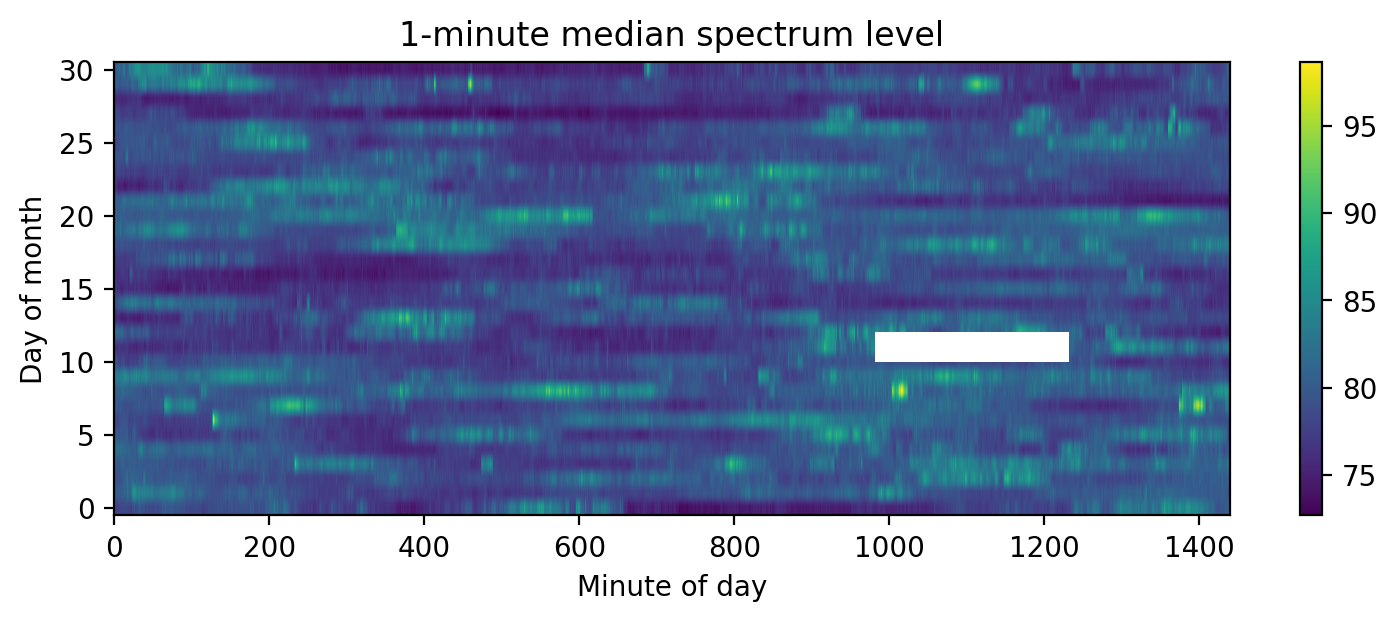

In [14]:
plt.figure(dpi=200, figsize = [9,3])
plt.imshow(L50m,aspect='auto',origin='lower')
plt.xlabel('Minute of day')
plt.ylabel('Day of month')
plt.title('1-minute median spectrum level')
plt.colorbar()

The white band in the plot above indicates missing data, as illustrated by the zero count below.

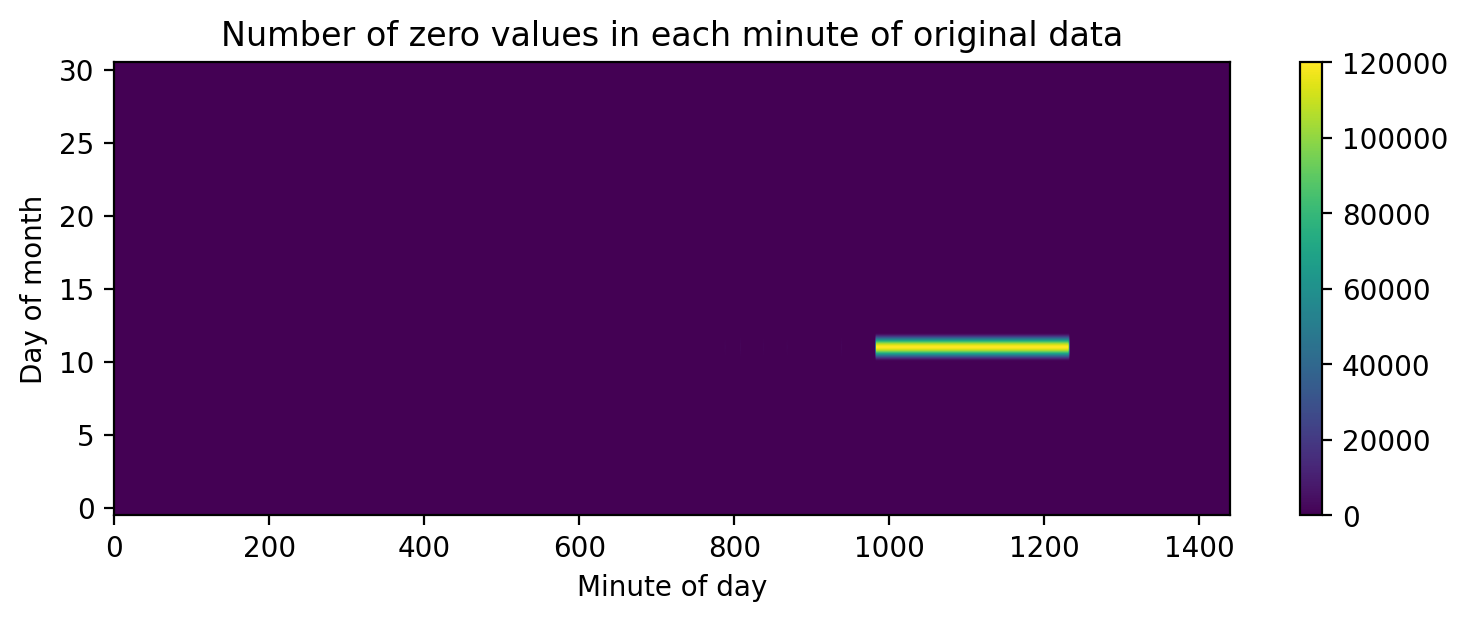

In [15]:
plt.figure(dpi=200, figsize = [9,3])
plt.imshow(zero_count_daily,aspect='auto',origin='lower')
plt.xlabel('Minute of day')
plt.ylabel('Day of month')
plt.title('Number of zero values in each minute of original data')
plt.colorbar()

While it is useful to examine the computed statistics in the arrays in which they were accumulated, as above, box plots are a more effective way to summarize the results.  The example below does not handle the missing data on days 21 and 22 effectively, but it illustrates how graphic examination of the interquartile range can provide an effective summary of day-to-day variations.

Text(0, 0.5, 'Spectrum level (dB re 1 $\\mu$Pa$^2$/Hz)')

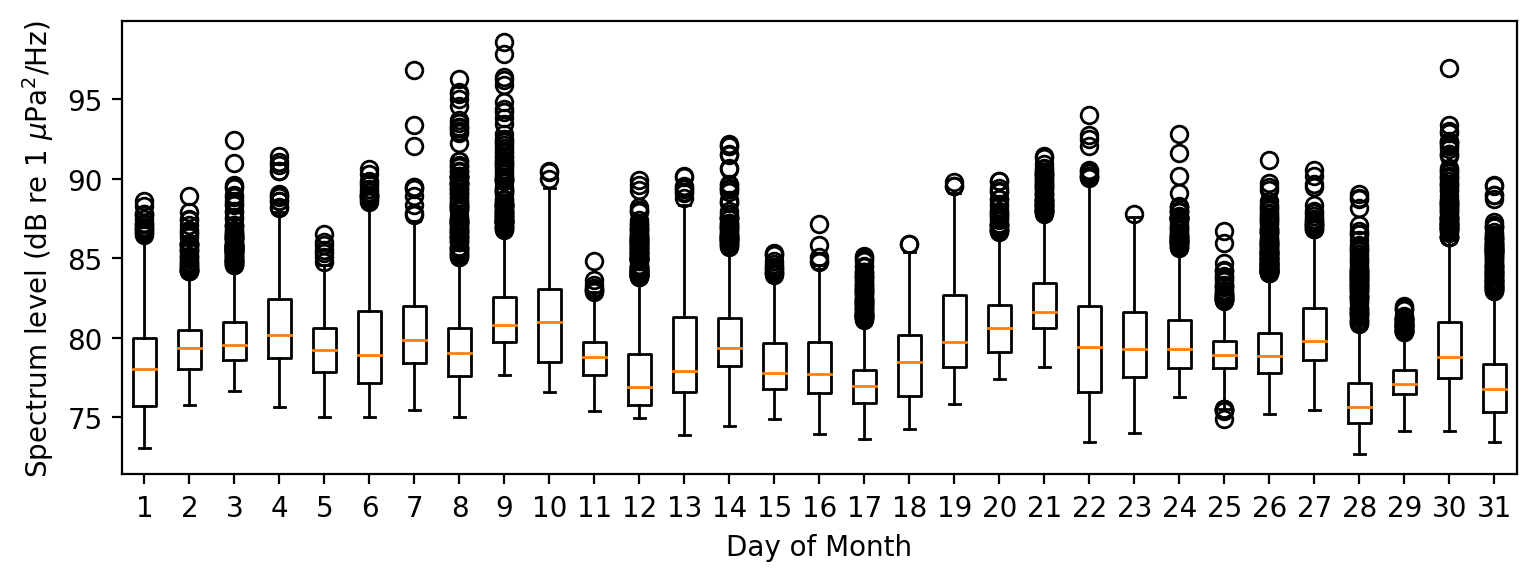

In [16]:
plt.figure(dpi=200, figsize = [9,3])
plt.boxplot(np.array(L50m).T)
plt.xlabel('Day of Month')
plt.ylabel('Spectrum level (dB re 1 $\mu$Pa$^2$/Hz)')

## References
Dekeling, R. P. A., Tasker, M. L., Van der Graaf, A. J., Ainslie, M. A., Andersson, M. H., Andreì, M., et al. (2014). Monitoring Guidance for Underwater Noise in European Seas, Part II: Monitoring Guidance Specifications, JRC Scientific and Policy Report EUR 26555 EN. Luxembourg: Publications Office of the European Union.

ISO, (2017). International Standard ISO 18405:2017(E), Underwater Acoustics – Terminology. Geneva: ISO.